In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset
                                                  
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.nips.data_sets.shape_net import pc_loader as sn_pc_loader
from tf_lab.point_clouds.raw_gan import RawGAN
from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.point_net_aae import PointNetAdversarialAutoEncoder


from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, jensen_shannon_divergence, \
                                     sample_pclouds_distances

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.autopredictors.exploration import find_neighbors

from tf_lab.nips.helper import pclouds_centered_and_half_sphere

from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, latent_code_generator_two_layers    

from tf_lab.icml.ae_farm_helper import relevant_class

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
class_name = raw_input('Give me the class type: ').lower()
n_pc_samples = 2048
do_training = True
do_plotting = True
ae_loss = 'emd'

syn_id = shape_net_category_to_synth_id()[class_name]
bneck_size = int(raw_input('Give me the AE bneck size:'))

                 
# save_synthetic_samples = True
# save_model = True
# saver_step = 10

# ae_id = raw_input('Give me the AE/experiment ID: ').lower()
# cmp_type = raw_input('Comparison Type ("best" epoch vs. "max_min" epoch): ').lower()

# experiment_name = '_'.join(['nb_wgan_gp_ae', ae_id, ae_loss, class_name, str(n_pc_samples), cmp_type, 'epoch'])
# synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/icml/synthetic_point_clouds'

# train_dir = osp.join(top_data_dir, 'OUT/icml/nn_models/gan/nb_gan')
# train_dir = osp.join(train_dir, experiment_name)
# create_dir(train_dir);

Give me the class type: chair
Give me the AE bneck size:8


In [5]:
# Load Raw Point-Clouds of class
pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
pclouds_path = osp.join(pclouds_path, syn_id)
file_names = pio.load_filenames_of_input_data(pclouds_path, '.ply')
pclouds, model_ids, syn_ids = pio.load_crude_point_clouds(file_names=file_names, n_threads=50, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(pclouds), )
train_data = PointCloudDataSet(pclouds)

6778 files containing complete point clouds were found.


In [6]:
experiment_name = 'aee_' + class_name + '_conv_arch_bneck_' + str(bneck_size) + '_2048pts_' + ae_loss
train_dir = osp.join(top_data_dir, 'OUT/models/nips/adversarial_ae', experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/adversarial_ae/aee_chair_conv_arch_bneck_8_2048pts_emd'

In [7]:
n_input = [n_pc_samples, 3]

decoder_args = {'layer_sizes': [1024, 2048, np.prod(n_input)] }

encoder_args = {'n_filters': [128, 128, 256, bneck_size],
                'filter_sizes': [40, 20, 10, 10],
                'strides': [1, 2, 2, 1]}

conf = Conf(
            n_input = n_input,
            training_epochs = 1000,
            batch_size = 50,
            loss = ae_loss,
            denoising = False,
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = 10,
            learning_rate = 0.0005,
            z_rotate = False,
            encoder = enc_dec.encoder_with_convs_and_symmetry,
            encoder_args = encoder_args,
            decoder = enc_dec.decoder_with_fc_only,
            decoder_args = decoder_args,        
           )

conf.lr_adv = 0.00001
conf.beta_adv = 0

conf.experiment_name = experiment_name
conf.save(osp.join(conf.train_dir, 'configuration'))

In [8]:
discriminator = latent_code_discriminator_two_layers
noise_dim = bneck_size
reset_tf_graph()
aae = PointNetAdversarialAutoEncoder(experiment_name, conf, noise_dim, discriminator)

In [9]:
if do_training:
#     buf_size = 1 # flush each line
#     fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
    train_stats = aae.train(train_data, conf)
#     fout.close()

('Epoch:', '0001', 'training time (minutes)=', '0.5603', 'loss', array([ 233.1743615 ,    1.29029893,    0.76153287]))
INFO:tensorflow:/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/adversarial_ae/aee_chair_conv_arch_bneck_8_2048pts_emd/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
('Epoch:', '0002', 'training time (minutes)=', '0.5271', 'loss', array([ 179.94914099,    1.12399512,    0.81519943]))
('Epoch:', '0003', 'training time (minutes)=', '0.5289', 'loss', array([ 173.20938054,    1.00575007,    0.83091478]))
('Epoch:', '0004', 'training time (minutes)=', '0.5397', 'loss', array([ 167.50082703,    0.90157461,    0.85673292]))
('Epoch:', '0005', 'training time (minutes)=', '0.5368', 'loss', array([ 164.09832741,    0.81251519,    0.88863732]))
('Epoch:', '0006', 'training time (minutes)=', '0.5460', 'loss', array([ 162.4643679 ,    0.73350657,    0.93184206]))
('Epoch:', '0007', 'training time (minutes)=', '0.5397', 'loss', array([ 160.12626

ResourceExhaustedError: /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/adversarial_ae/aee_chair_conv_arch_bneck_8_2048pts_emd/models.ckpt-100.data-00000-of-00001
	 [[Node: aee_chair_conv_arch_bneck_8_2048pts_emd_1/save/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_BOOL, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT32, DT_INT32, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_aee_chair_conv_arch_bneck_8_2048pts_emd_1/save/Const_0, aee_chair_conv_arch_bneck_8_2048pts_emd_1/save/SaveV2/tensor_names, aee_chair_conv_arch_bneck_8_2048pts_emd_1/save/SaveV2/shape_and_slices, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/W/_665, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/b/_667, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/beta/_669, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/gamma/_671, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/moving_mean/_673, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/moving_variance/_675, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/W/_677, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/b/_679, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/beta/_681, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/gamma/_683, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/moving_mean/_685, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/moving_variance/_687, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/W/_689, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/b/_691, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/W, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/b/_693, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/beta/_695, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/gamma/_697, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/moving_mean/_699, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/moving_variance/_701, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/W/_703, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/b/_705, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/beta/_707, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/gamma/_709, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/moving_mean/_711, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/moving_variance/_713, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/W/_715, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/b/_717, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/W/_719, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/W, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/b/_721, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/beta/_723, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/gamma/_725, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/is_training, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/moving_mean/_727, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/moving_variance/_729, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/W/_731, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/b/_733, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/beta/_735, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/gamma/_737, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/moving_mean/_739, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/moving_variance/_741, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/W/_743, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/b/_745, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/beta/_747, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/gamma/_749, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/moving_mean/_751, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/moving_variance/_753, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/W/_755, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/b/_757, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/beta/_759, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/gamma/_761, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/moving_mean/_763, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/moving_variance/_765, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/b/_767, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/beta/_769, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/gamma/_771, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/moving_mean/_773, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/moving_variance/_775, aee_chair_conv_arch_bneck_8_2048pts_emd/epoch, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/W/Adam/_777, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/W/Adam_1/_779, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/b/Adam/_781, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/b/Adam_1/_783, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/beta/Adam/_785, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/beta/Adam_1/_787, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/gamma/Adam/_789, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/gamma/Adam_1/_791, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/W/Adam/_793, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/W/Adam_1/_795, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/b/Adam/_797, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/b/Adam_1/_799, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/beta/Adam/_801, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/beta/Adam_1/_803, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/gamma/Adam/_805, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/gamma/Adam_1/_807, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/W/Adam/_809, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/W/Adam_1/_811, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/b/Adam/_813, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/b/Adam_1/_815, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/W/Adam, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/W/Adam_1, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/b/Adam/_817, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/b/Adam_1/_819, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/beta/Adam/_821, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/beta/Adam_1/_823, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/gamma/Adam/_825, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/gamma/Adam_1/_827, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/W/Adam/_829, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/W/Adam_1/_831, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/b/Adam/_833, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/b/Adam_1/_835, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/beta/Adam/_837, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/beta/Adam_1/_839, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/gamma/Adam/_841, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/gamma/Adam_1/_843, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/W/Adam/_845, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/W/Adam_1/_847, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/b/Adam/_849, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/b/Adam_1/_851, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/W/Adam/_853, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/W/Adam_1/_855, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/W/Adam_2/_857, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/W/Adam_3/_859, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/W/Adam, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/W/Adam_1, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/W/Adam_2, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/W/Adam_3, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/b/Adam/_861, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/b/Adam_1/_863, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/b/Adam_2/_865, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/b/Adam_3/_867, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/beta/Adam/_869, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/beta/Adam_1/_871, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/beta/Adam_2/_873, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/beta/Adam_3/_875, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/gamma/Adam/_877, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/gamma/Adam_1/_879, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/gamma/Adam_2/_881, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/gamma/Adam_3/_883, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/W/Adam/_885, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/W/Adam_1/_887, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/W/Adam_2/_889, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/W/Adam_3/_891, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/b/Adam/_893, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/b/Adam_1/_895, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/b/Adam_2/_897, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/b/Adam_3/_899, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/beta/Adam/_901, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/beta/Adam_1/_903, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/beta/Adam_2/_905, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/beta/Adam_3/_907, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/gamma/Adam/_909, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/gamma/Adam_1/_911, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/gamma/Adam_2/_913, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/gamma/Adam_3/_915, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/W/Adam/_917, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/W/Adam_1/_919, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/W/Adam_2/_921, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/W/Adam_3/_923, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/b/Adam/_925, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/b/Adam_1/_927, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/b/Adam_2/_929, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/b/Adam_3/_931, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/beta/Adam/_933, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/beta/Adam_1/_935, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/beta/Adam_2/_937, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/beta/Adam_3/_939, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/gamma/Adam/_941, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/gamma/Adam_1/_943, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/gamma/Adam_2/_945, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/gamma/Adam_3/_947, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/W/Adam/_949, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/W/Adam_1/_951, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/W/Adam_2/_953, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/W/Adam_3/_955, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/b/Adam/_957, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/b/Adam_1/_959, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/b/Adam_2/_961, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/b/Adam_3/_963, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/beta/Adam/_965, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/beta/Adam_1/_967, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/beta/Adam_2/_969, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/beta/Adam_3/_971, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/gamma/Adam/_973, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/gamma/Adam_1/_975, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/gamma/Adam_2/_977, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/gamma/Adam_3/_979, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/b/Adam/_981, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/b/Adam_1/_983, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/b/Adam_2/_985, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/b/Adam_3/_987, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/beta/Adam/_989, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/beta/Adam_1/_991, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/beta/Adam_2/_993, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/beta/Adam_3/_995, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/gamma/Adam/_997, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/gamma/Adam_1/_999, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/gamma/Adam_2/_1001, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/gamma/Adam_3/_1003, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta1_power, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta1_power_1, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta1_power_2, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta2_power, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta2_power_1, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta2_power_2)]]

Caused by op u'aee_chair_conv_arch_bneck_8_2048pts_emd_1/save/SaveV2', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-a5d5b3841803>", line 4, in <module>
    aae = PointNetAdversarialAutoEncoder(experiment_name, conf, noise_dim, discriminator)
  File "/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/point_clouds/point_net_aae.py", line 72, in __init__
    self.saver = tf.train.Saver(tf.global_variables(), max_to_keep=c.saver_max_to_keep)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 622, in build
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 229, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 172, in save_op
    tensors)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 552, in save_v2
    tensors=tensors, name=name)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/orions4-zfs/projects/lins2/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): /orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/nips/adversarial_ae/aee_chair_conv_arch_bneck_8_2048pts_emd/models.ckpt-100.data-00000-of-00001
	 [[Node: aee_chair_conv_arch_bneck_8_2048pts_emd_1/save/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_BOOL, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_INT32, DT_INT32, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_aee_chair_conv_arch_bneck_8_2048pts_emd_1/save/Const_0, aee_chair_conv_arch_bneck_8_2048pts_emd_1/save/SaveV2/tensor_names, aee_chair_conv_arch_bneck_8_2048pts_emd_1/save/SaveV2/shape_and_slices, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/W/_665, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/b/_667, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/beta/_669, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/gamma/_671, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/moving_mean/_673, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/moving_variance/_675, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/W/_677, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/b/_679, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/beta/_681, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/gamma/_683, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/moving_mean/_685, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/moving_variance/_687, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/W/_689, aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/b/_691, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/W, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/b/_693, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/beta/_695, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/gamma/_697, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/moving_mean/_699, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/moving_variance/_701, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/W/_703, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/b/_705, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/beta/_707, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/gamma/_709, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/moving_mean/_711, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/moving_variance/_713, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/W/_715, aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/b/_717, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/W/_719, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/W, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/b/_721, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/beta/_723, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/gamma/_725, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/is_training, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/moving_mean/_727, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/moving_variance/_729, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/W/_731, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/b/_733, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/beta/_735, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/gamma/_737, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/moving_mean/_739, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/moving_variance/_741, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/W/_743, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/b/_745, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/beta/_747, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/gamma/_749, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/moving_mean/_751, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/moving_variance/_753, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/W/_755, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/b/_757, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/beta/_759, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/gamma/_761, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/moving_mean/_763, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/moving_variance/_765, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/b/_767, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/beta/_769, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/gamma/_771, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/moving_mean/_773, aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/moving_variance/_775, aee_chair_conv_arch_bneck_8_2048pts_emd/epoch, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/W/Adam/_777, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/W/Adam_1/_779, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/b/Adam/_781, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0/b/Adam_1/_783, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/beta/Adam/_785, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/beta/Adam_1/_787, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/gamma/Adam/_789, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_0_bnorm/gamma/Adam_1/_791, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/W/Adam/_793, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/W/Adam_1/_795, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/b/Adam/_797, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1/b/Adam_1/_799, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/beta/Adam/_801, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/beta/Adam_1/_803, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/gamma/Adam/_805, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_1_bnorm/gamma/Adam_1/_807, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/W/Adam/_809, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/W/Adam_1/_811, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/b/Adam/_813, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/aee_chair_conv_arch_bneck_8_2048pts_emd/decoder/decoder_fc_2/b/Adam_1/_815, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/W/Adam, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/W/Adam_1, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/b/Adam/_817, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0/b/Adam_1/_819, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/beta/Adam/_821, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/beta/Adam_1/_823, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/gamma/Adam/_825, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_0_bnorm/gamma/Adam_1/_827, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/W/Adam/_829, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/W/Adam_1/_831, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/b/Adam/_833, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1/b/Adam_1/_835, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/beta/Adam/_837, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/beta/Adam_1/_839, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/gamma/Adam/_841, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_1_bnorm/gamma/Adam_1/_843, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/W/Adam/_845, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/W/Adam_1/_847, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/b/Adam/_849, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/aee_chair_conv_arch_bneck_8_2048pts_emd/discriminator/decoder_fc_2/b/Adam_1/_851, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/W/Adam/_853, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/W/Adam_1/_855, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/W/Adam_2/_857, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/W/Adam_3/_859, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/W/Adam, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/W/Adam_1, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/W/Adam_2, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/W/Adam_3, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/b/Adam/_861, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/b/Adam_1/_863, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/b/Adam_2/_865, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0/b/Adam_3/_867, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/beta/Adam/_869, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/beta/Adam_1/_871, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/beta/Adam_2/_873, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/beta/Adam_3/_875, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/gamma/Adam/_877, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/gamma/Adam_1/_879, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/gamma/Adam_2/_881, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_0_bnorm/gamma/Adam_3/_883, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/W/Adam/_885, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/W/Adam_1/_887, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/W/Adam_2/_889, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/W/Adam_3/_891, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/b/Adam/_893, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/b/Adam_1/_895, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/b/Adam_2/_897, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1/b/Adam_3/_899, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/beta/Adam/_901, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/beta/Adam_1/_903, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/beta/Adam_2/_905, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/beta/Adam_3/_907, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/gamma/Adam/_909, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/gamma/Adam_1/_911, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/gamma/Adam_2/_913, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_1_bnorm/gamma/Adam_3/_915, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/W/Adam/_917, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/W/Adam_1/_919, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/W/Adam_2/_921, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/W/Adam_3/_923, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/b/Adam/_925, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/b/Adam_1/_927, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/b/Adam_2/_929, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2/b/Adam_3/_931, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/beta/Adam/_933, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/beta/Adam_1/_935, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/beta/Adam_2/_937, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/beta/Adam_3/_939, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/gamma/Adam/_941, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/gamma/Adam_1/_943, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/gamma/Adam_2/_945, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_2_bnorm/gamma/Adam_3/_947, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/W/Adam/_949, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/W/Adam_1/_951, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/W/Adam_2/_953, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/W/Adam_3/_955, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/b/Adam/_957, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/b/Adam_1/_959, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/b/Adam_2/_961, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3/b/Adam_3/_963, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/beta/Adam/_965, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/beta/Adam_1/_967, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/beta/Adam_2/_969, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/beta/Adam_3/_971, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/gamma/Adam/_973, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/gamma/Adam_1/_975, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/gamma/Adam_2/_977, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/encoder_conv_layer_3_bnorm/gamma/Adam_3/_979, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/b/Adam/_981, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/b/Adam_1/_983, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/b/Adam_2/_985, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/b/Adam_3/_987, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/beta/Adam/_989, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/beta/Adam_1/_991, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/beta/Adam_2/_993, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/beta/Adam_3/_995, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/gamma/Adam/_997, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/gamma/Adam_1/_999, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/gamma/Adam_2/_1001, aee_chair_conv_arch_bneck_8_2048pts_emd_1/aee_chair_conv_arch_bneck_8_2048pts_emd/encoder/gamma/Adam_3/_1003, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta1_power, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta1_power_1, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta1_power_2, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta2_power, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta2_power_1, aee_chair_conv_arch_bneck_8_2048pts_emd_1/beta2_power_2)]]


In [28]:
feed = train_data.next_batch(10)[0]
aae.loss = aae.structural_loss
rec = aae.reconstruct(feed)[0]

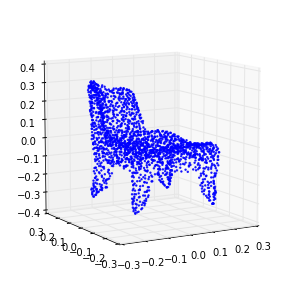

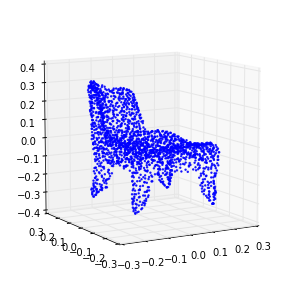

In [29]:
Point_Cloud(rec[0]).plot()